#Импорт необходимых библиотек

In [115]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop 
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence, tokenizer_from_json 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback 
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  
from sklearn.cluster import KMeans
import random 
import math 
import re 
import matplotlib.pyplot as plt 
%matplotlib inline
from IPython.display import clear_output
 

#Загрузка данных, проверка содержимого

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename_1 = '/content/drive/MyDrive/Profpatolog/dataset_profpatolog_1.csv'
filename_2 = '/content/drive/MyDrive/Profpatolog/dataset_profpatolog_2.csv'

In [4]:
df = pd.read_csv(filename_1)

In [118]:
print(df.shape)

(112, 710)


In [6]:
df.count()

ДокументПрохождениеМедосмотра                             112
Клиент                                                    110
КлиентДатаРождения                                        110
КлиентПол                                                 110
КлиентПолПредставление                                    110
                                                         ... 
Стоматология1_Противопоказание2                             2
Стоматология1_ПротивопоказаниеПредставление2                0
Стоматология1_Профессиональное2                             2
Стоматология1_ПрофнепригодностьВременная2                   0
Стоматология1_ПрофнепригодностьВременнаяПредставление2      0
Length: 710, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Columns: 710 entries, ДокументПрохождениеМедосмотра to Стоматология1_ПрофнепригодностьВременнаяПредставление2
dtypes: float64(267), object(443)
memory usage: 621.4+ KB


#Работа с данными в таблице

In [8]:
df1 = df.dropna(axis=0, how='all')
df2 = df1.dropna(axis=1, how='all')

In [9]:
print(df2.shape)

(112, 470)


In [10]:
colms = df2.columns.values.tolist()

In [11]:
colms[3]

'КлиентПол'

In [12]:
df2[colms[3]].unique()

array(['Женский', 'Мужской', nan], dtype=object)

In [13]:
df2[colms[3]].nunique()

2

In [14]:
print(df2.iloc[33])

ДокументПрохождениеМедосмотра                                    назначено лечение."
Клиент                                                                           NaN
КлиентДатаРождения                                                               NaN
КлиентПол                                                                        NaN
КлиентПолПредставление                                                           NaN
                                                                        ...         
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                    NaN
Стоматология1_МКБ102                                                             NaN
Стоматология1_ДиагнозПредставление2                                              NaN
Стоматология1_Противопоказание2                                                  NaN
Стоматология1_Профессиональное2                                                  NaN
Name: 33, Length: 470, dtype: object


In [15]:
print(df2.iloc[60])

ДокументПрохождениеМедосмотра                                    конс сурдолога к след мед осмотру."
Клиент                                                                                           NaN
КлиентДатаРождения                                                                               NaN
КлиентПол                                                                                        NaN
КлиентПолПредставление                                                                           NaN
                                                                                ...                 
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                                    NaN
Стоматология1_МКБ102                                                                             NaN
Стоматология1_ДиагнозПредставление2                                                              NaN
Стоматология1_Противопоказание2                                                            

In [16]:
df3 = df2.drop (index=[ 33, 60, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111])

In [18]:
print(df3.shape)

(100, 470)


In [19]:
data = []
for col in colms:
    tp = df3[col].dtypes
    q = df3[col].unique()
    nq = df3[col].nunique()
    data.append([col, tp, nq, q])

In [20]:
df_col = pd.DataFrame(data, columns=['Название', 'Тип', 'Кол-во уник.знач.', 'Уник.значения'])

In [21]:
df_col[0:17]

,Название,Тип,Кол-во уник.знач.,Уник.значения
0,ДокументПрохождениеМедосмотра,object,100,"[9688ac7c-dd74-11ec-8100-0cc47aab8067, df26abd..."
1,Клиент,object,100,"[11ba74dd-5503-11e8-80ce-0cc47aab8067, 11ba74d..."
2,КлиентДатаРождения,object,99,"[1972-03-05, 1988-09-16, 2002-05-26, 1968-03-1..."
3,КлиентПол,object,2,"[Женский, Мужской]"
4,КлиентПолПредставление,object,2,"[Женский, Мужской]"
5,ДатаЗавершенияМедосмотра,object,24,"[2022-05-27, 2022-05-30, 2022-05-31, 2022-06-0..."
6,ТипМедосмотра,object,1,[Периодический]
7,ТипМедосмотраПредставление,object,1,[Периодический]
8,ПсихОсвидетельствование,float64,2,"[0.0, 1.0]"
9,Контрагент,object,13,"[a1e92db1-2ea1-11e9-80ce-0cc47aab8067, e8b7052..."


In [22]:
df_col.iloc[12][3]

array(['ГоденСКоррекциейЗрения', 'Годен', 'ГоденБезРаботНаВысотах',
       'ВременноНегоден', 'ОграниченноГоден'], dtype=object)

In [23]:
df_col.iloc[13][3]

array(['Годен к работе в указанных условиях (с коррекцией зрения)',
       'Годен к работе в указанных условиях',
       'Годен к работе в указанных условиях (без работ на высотах)',
       'Временно не годен', 'Ограниченно годен'], dtype=object)

In [24]:
df_col.iloc[14][3]

array(['Годен к работе в указанных условиях (с коррекцией зрения), кроме п.6.1',
       'Годен к работе в указанных условиях',
       'Годен к работе в указанных условиях (с коррекцией зрения)',
       'Годен к работе в указанных условиях (без работ на высотах) Противопоказана работа связанная с  высотой ,подьем и перемещение тяжестей ,длительной ходьбой.',
       'Временно не годен', 'Ограниченно годен',
       'Годен к работе в указанных условиях, кроме п 6.2', nan],
      dtype=object)

In [25]:
df_col.iloc[15][3]

array(['II', 'I', 'IIIа', 'IIIб'], dtype=object)

In [26]:
df_col.iloc[17][3]

array(['5.1,6.1,6.2', '5.1,6', '4.2.5', '5.1,6.2,6.1', '5.1', '6.1,9,15',
       '4.7,4.8,5.1', '6.1,15', '18.1', '11.1,18.2', '25', '6.2,9', '23',
       '18,18.1,18.2', '11.1,18.1,18.2', '4.7,5.1,11.1', '11.1,18.1',
       '8,11.1,18.2', '4.3.1,4.3.2,8', '6.1,9', '4.4,5.1,6.1,15', '15',
       '9,6.2', '4.2.5,6.2,9', '18.1,22', '4.2.5,6.2,9,27',
       '1.36,4.7,5.1,11.1', '1.29.1,5.1,6.1,9,11.1,15', '23,25', '22',
       '4.1,6.2,18.1,18.2', '4.1,6.2', '4.1,4.2.5,4.4', '6.2,4.1', '4.1',
       '4.1,4.2.5', '4.1,4.7,4.8,5.1', '4.2.5,6.2', '4.1,4.7,4.8,5.1,6.2',
       '9,6.1,6.2'], dtype=object)

In [27]:
df_col.iloc[100][3]

array(['ХР_ГоденКромеПунктов', 'БИТУФА_НеВыявлена', nan], dtype=object)

In [28]:
df_col.iloc[101][3]

array(['Годен, кроме п.', 'Годен', nan], dtype=object)

In [29]:
df4 = df3[['Клиент', 'КлиентДатаРождения', 'КлиентПол', 'ТипМедосмотра', 'ПсихОсвидетельствование', 'Цех', 'Профессия', 'ЗаключениеМК', 'ДиспансернаяГруппа', 'ВредныеФакторы', 'Оториноларингология1_СалонПредставление', 'Оториноларингология1_МКБ101', 'Оториноларингология1_ДиагнозПредставление1', 'Оториноларингология1_Детализация1', 'Оториноларингология1_ПрофнепригодностьВременная1', 'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1', 'Гинекология1_СалонПредставление', 'Гинекология1_СпециализацияПредставление', 'Гинекология1_ХР_Рекомендация1Представление', 'Гинекология1_ХР_Рекомендация2Представление', 'Гинекология1_ХР_РекомендацияСтр', 'Хирургия1_СалонПредставление', 'Хирургия1_СпециализацияПредставление', 'Хирургия1_ХР_Рекомендация1', 'Хирургия1_ХР_Рекомендация2', 'Хирургия1_МКБ101', 'Хирургия1_ДиагнозПредставление1', 'Хирургия1_Детализация1', 'Хирургия1_Профессиональное1', 'Хирургия1_ПрофнепригодностьВременная1', 'Хирургия1_ПрофнепригодностьВременнаяПредставление1', 'Офтальмология1_СалонПредставление', 'Офтальмология1_СпециализацияПредставление', 'Офтальмология1_ХР_Рекомендация1Представление', 'Офтальмология1_ХР_Рекомендация2Представление', 'Офтальмология1_МКБ101', 'Офтальмология1_ДиагнозПредставление1', 'Офтальмология1_Детализация1', 'Офтальмология1_Классификация11', 'Офтальмология1_Классификация1Представление1', 'Офтальмология1_Классификация21', 'Офтальмология1_Классификация31', 'Офтальмология1_Профессиональное1', 'Офтальмология1_ПрофнепригодностьВременнаяПредставление1', 'Рентгенология1_МКБ101', 'Рентгенология1_ПрофнепригодностьВременнаяПредставление1', 'Психиатрия_Наркология1_СпециализацияПредставление', 'Психиатрия_Наркология1_ХР_РекомендацияСтр', 'Психиатрия_Наркология1_МКБ101', 'Психиатрия_Наркология1_ДиагнозПредставление1', 'Психиатрия_Наркология1_Классификация11', 'Психиатрия_Наркология1_Классификация1Представление1', 'Психиатрия_Наркология1_ПрофнепригодностьВременная1', 'Психиатрия_Наркология1_ПрофнепригодностьВременнаяПредставление1', 'Психиатрия_Наркология2_СпециализацияПредставление', 'Психиатрия_Наркология2_МКБ101', 'Психиатрия_Наркология2_ДиагнозПредставление1', 'Психиатрия_Наркология2_ПрофнепригодностьВременнаяПредставление1', 'Неврология1_СпециализацияПредставление', 'Неврология1_МКБ101', 'Неврология1_ДиагнозПредставление1', 'Неврология1_Детализация1', 'Неврология1_Классификация21', 'Неврология1_ПрофнепригодностьВременнаяПредставление1', 'Терапия1_СпециализацияПредставление', 'Терапия1_ХР_Рекомендация1Представление', 'Терапия1_ХР_Рекомендация2Представление', 'Терапия1_МКБ101', 'Терапия1_ДиагнозПредставление1', 'Терапия1_Детализация1', 'Терапия1_Классификация11', 'Терапия1_Классификация1Представление1', 'Терапия1_ПрофнепригодностьВременная1', 'Терапия1_ПрофнепригодностьВременнаяПредставление1', 'Гинекология1_МКБ101', 'Гинекология1_ДиагнозПредставление1', 'Гинекология1_ПрофнепригодностьВременная1', 'Гинекология1_ПрофнепригодностьВременнаяПредставление1', 'Дерматовенерология1_СпециализацияПредставление', 'Дерматовенерология1_ХР_Рекомендация1Представление', 'Дерматовенерология1_ХР_Рекомендация2Представление', 'Дерматовенерология1_МКБ101', 'Дерматовенерология1_ДиагнозПредставление1', 'Дерматовенерология1_Классификация11', 'Дерматовенерология1_Классификация1Представление1', 'Дерматовенерология1_Классификация21', 'Дерматовенерология1_ПрофнепригодностьВременная1', 'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1', 'Терапия1_МКБ102', 'Терапия1_ДиагнозПредставление2', 'Лабораторные_Исследования1_МКБ101', 'Лабораторные_Исследования1_ДиагнозПредставление1', 'Лабораторные_Исследования1_ПрофнепригодностьВременная1', 'Лабораторные_Исследования1_ПрофнепригодностьВременнаяПредставление1', 'Терапия2_СпециализацияПредставление', 'Терапия2_ХР_Рекомендация1Представление', 'Терапия2_ХР_Рекомендация2Представление', 'Терапия2_МКБ101', 'Терапия2_ДиагнозПредставление1', 'Терапия2_Детализация1', 'Терапия2_Классификация11', 'Терапия2_Классификация1Представление1', 'Терапия2_ПрофнепригодностьВременная1', 'Терапия2_ПрофнепригодностьВременнаяПредставление1', 'Хирург_Не_Исп_1_СпециализацияПредставление', 'Хирург_Не_Исп_1_МКБ101', 'Хирург_Не_Исп_1_ДиагнозПредставление1', 'Хирург_Не_Исп_1_ПрофнепригодностьВременная1', 'Хирург_Не_Исп_1_ПрофнепригодностьВременнаяПредставление1', 'Лабораторные_Исследования2_МКБ101', 'Лабораторные_Исследования2_ПрофнепригодностьВременная1', 'Лабораторные_Исследования2_ПрофнепригодностьВременнаяПредставление1', 'УЗИ_Диагностика1_МКБ101', 'УЗИ_Диагностика1_ДиагнозПредставление1', 'УЗИ_Диагностика1_ПрофнепригодностьВременная1', 'УЗИ_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 'Терапия1_МКБ103', 'Терапия1_ДиагнозПредставление3', 'Процедурная_Медсестра1_МКБ101', 'Процедурная_Медсестра1_ДиагнозПредставление1', 'Процедурная_Медсестра1_ПрофнепригодностьВременная1', 'Процедурная_Медсестра1_ПрофнепригодностьВременнаяПредставление1', 'Психиатрия1_СпециализацияПредставление', 'Психиатрия1_МКБ101', 'Психиатрия1_ДиагнозПредставление1', 'Психиатрия1_ПрофнепригодностьВременная1', 'Психиатрия1_ПрофнепригодностьВременнаяПредставление1', 'Стоматология1_СпециализацияПредставление', 'Стоматология1_ХР_Рекомендация1Представление', 'Эндоскопия1_СпециализацияПредставление', 'Эндоскопия2_СпециализацияПредставление', 'Функциональная_Диагностика1_МКБ101', 'Функциональная_Диагностика1_ДиагнозПредставление1', 'Функциональная_Диагностика1_ПрофнепригодностьВременная1', 'Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 'Стоматология1_МКБ101', 'Стоматология1_ДиагнозПредставление1', 'Стоматология1_ПрофнепригодностьВременная1', 'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 'Неврология1_МКБ102', 'Неврология1_ДиагнозПредставление2', 'Гинекология2_СпециализацияПредставление', 'Офтальмология1_МКБ102', 'Офтальмология1_ДиагнозПредставление2', 'УЗИ_Диагностика1_МКБ102', 'УЗИ_Диагностика1_ДиагнозПредставление2', 'Оториноларингология1_МКБ102']]

In [30]:
print(df4.shape)

(100, 147)


In [31]:
colms2 = df4.columns.values.tolist()

In [32]:
data = []
for col in colms2:
    tp = df4[col].dtypes
    q = df4[col].unique()
    nq = df4[col].nunique()
    data.append([col, tp, nq, q])

In [33]:
df_col2 = pd.DataFrame(data, columns=['Название', 'Тип', 'Кол-во уник.знач.', 'Уник.значения'])

In [34]:
df_col2[135:147]

,Название,Тип,Кол-во уник.знач.,Уник.значения
135,Стоматология1_МКБ101,object,1,"[nan, Z00.0]"
136,Стоматология1_ДиагнозПредставление1,object,1,"[nan, Общий медицинский осмотр]"
137,Стоматология1_ПрофнепригодностьВременная1,object,1,"[nan, БИТУФА_НеВыявлена]"
138,Стоматология1_ПрофнепригодностьВременнаяПредст...,object,1,"[nan, Годен]"
139,Неврология1_МКБ102,object,1,"[nan, I11.9]"
140,Неврология1_ДиагнозПредставление2,object,1,"[nan, Гипертензивная [гипертоническая] болезнь..."
141,Гинекология2_СпециализацияПредставление,object,1,"[nan, Гинекология]"
142,Офтальмология1_МКБ102,object,1,"[nan, I25.8]"
143,Офтальмология1_ДиагнозПредставление2,object,1,"[nan, Другие формы хронической ишемической бол..."
144,УЗИ_Диагностика1_МКБ102,object,1,"[nan, K80.2]"


In [35]:
#Формирование таблицы с нужными стобцами
df5 = df4[['КлиентПол', 
           'КлиентДатаРождения',
           'ТипМедосмотра', 
           'ДиспансернаяГруппа', 
           'Оториноларингология1_МКБ101', 
           'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1', 
           'Хирургия1_МКБ101', 
           'Хирургия1_ПрофнепригодностьВременнаяПредставление1', 
           'Офтальмология1_МКБ101', 
           'Офтальмология1_ПрофнепригодностьВременнаяПредставление1', 
           'Рентгенология1_МКБ101', 
           'Рентгенология1_ПрофнепригодностьВременнаяПредставление1', 
           'Психиатрия_Наркология1_МКБ101', 
           'Психиатрия_Наркология1_ПрофнепригодностьВременнаяПредставление1', 
           'Психиатрия_Наркология2_МКБ101', 
           'Психиатрия_Наркология2_ПрофнепригодностьВременнаяПредставление1', 
           'Неврология1_МКБ101', 
           'Неврология1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия1_МКБ101', 
           'Терапия1_ПрофнепригодностьВременнаяПредставление1', 
           'Гинекология1_МКБ101', 
           'Гинекология1_ПрофнепригодностьВременнаяПредставление1', 
           'Дерматовенерология1_МКБ101', 
           'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия1_МКБ102', 
           'Лабораторные_Исследования1_МКБ101',
           'Лабораторные_Исследования1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия2_МКБ101', 
           'Терапия2_ПрофнепригодностьВременнаяПредставление1', 
           'Хирург_Не_Исп_1_МКБ101', 
           'Хирург_Не_Исп_1_ПрофнепригодностьВременнаяПредставление1', 
           'Лабораторные_Исследования2_МКБ101', 
           'Лабораторные_Исследования2_ПрофнепригодностьВременнаяПредставление1', 
           'УЗИ_Диагностика1_МКБ101', 
           'УЗИ_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия1_МКБ103', 
           'Процедурная_Медсестра1_МКБ101', 
           'Процедурная_Медсестра1_ПрофнепригодностьВременнаяПредставление1', 
           'Психиатрия1_МКБ101',
           'Психиатрия1_ПрофнепригодностьВременнаяПредставление1', 
           'Функциональная_Диагностика1_МКБ101', 
           'Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
           'Стоматология1_МКБ101', 
           'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 
           'Неврология1_МКБ102', 
           'Офтальмология1_МКБ102', 
           'УЗИ_Диагностика1_МКБ102', 
           'Оториноларингология1_МКБ102'
           ]]

In [36]:
#Формирование таблицы с нужными стобцами
df6 = df4[['Клиент','КлиентДатаРождения', 'Профессия', 'ВредныеФакторы']]

In [37]:
print(df5.shape)

(100, 48)


In [38]:
df4.loc[(df4['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения')|(df4['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах')|(df4['ЗаключениеМК'] == 'ВременноНегоден'), 'ЗаключениеМК'] = 'ОграниченноГоден'


In [39]:
colms3 = df5.columns.values.tolist()
data = []
for col in colms3:
    tp = df5[col].dtypes
    q = df5[col].unique()
    nq = df5[col].nunique()
    data.append([col, tp, nq, q])

In [40]:
df_col3 = pd.DataFrame(data, columns=['Название', 'Тип', 'Кол-во уник.знач.', 'Уник.значения'])

In [41]:
df_col3[0:52]

,Название,Тип,Кол-во уник.знач.,Уник.значения
0,КлиентПол,object,2,"[Женский, Мужской]"
1,КлиентДатаРождения,object,99,"[1972-03-05, 1988-09-16, 2002-05-26, 1968-03-1..."
2,ТипМедосмотра,object,1,[Периодический]
3,ДиспансернаяГруппа,object,4,"[II, I, IIIа, IIIб]"
4,Оториноларингология1_МКБ101,object,3,"[Z00.0, nan, H90.3, H91.1]"
5,Оториноларингология1_ПрофнепригодностьВременна...,object,1,"[Годен, nan]"
6,Хирургия1_МКБ101,object,3,"[Z00.0, nan, S68.2, K40.9]"
7,Хирургия1_ПрофнепригодностьВременнаяПредставле...,object,2,"[Годен, nan, Временно не годен]"
8,Офтальмология1_МКБ101,object,7,"[H52.1, Z00.0, H52.0, nan, H11.0, H52.2, H50.9..."
9,Офтальмология1_ПрофнепригодностьВременнаяПредс...,object,2,"[Годен, кроме п., Годен, nan]"


#Парсим базу, создаем обучающую и проверочные выборки

In [42]:
# Данные о возрасте
def getParameterAge(arg):
    s = arg.split('-')
    out = 2023 - int(s[0])
    return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [43]:
df5['Возраст'] = df5['КлиентДатаРождения'].apply(getParameterAge)
df5['ВозрастнаяКатегория'] = df5['Возраст'].apply(getParameterAgeVect)
df5.drop(['КлиентДатаРождения', 'Возраст'], axis=1, inplace=True)

<ipython-input-43-927e14e80a53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Возраст'] = df5['КлиентДатаРождения'].apply(getParameterAge)
<ipython-input-43-927e14e80a53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['ВозрастнаяКатегория'] = df5['Возраст'].apply(getParameterAgeVect)
<ipython-input-43-927e14e80a53>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [44]:
#Преобразование в OHE
df_ohe = pd.get_dummies(df5, columns=['КлиентПол', 
                            'ВозрастнаяКатегория',          
                            'ТипМедосмотра', 
                            'ДиспансернаяГруппа', 
                            'Оториноларингология1_МКБ101', 
                            'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Хирургия1_МКБ101', 
                            'Хирургия1_ПрофнепригодностьВременнаяПредставление1', 
                            'Офтальмология1_МКБ101', 
                            'Офтальмология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Рентгенология1_МКБ101', 
                            'Рентгенология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Психиатрия_Наркология1_МКБ101', 
                            'Психиатрия_Наркология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Психиатрия_Наркология2_МКБ101', 
                            'Психиатрия_Наркология2_ПрофнепригодностьВременнаяПредставление1', 
                            'Неврология1_МКБ101', 
                            'Неврология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия1_МКБ101', 
                            'Терапия1_ПрофнепригодностьВременнаяПредставление1', 
                            'Гинекология1_МКБ101', 
                            'Гинекология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Дерматовенерология1_МКБ101', 
                            'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия1_МКБ102', 
                            'Лабораторные_Исследования1_МКБ101',
                            'Лабораторные_Исследования1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия2_МКБ101', 
                            'Терапия2_ПрофнепригодностьВременнаяПредставление1', 
                            'Хирург_Не_Исп_1_МКБ101', 
                            'Хирург_Не_Исп_1_ПрофнепригодностьВременнаяПредставление1', 
                            'Лабораторные_Исследования2_МКБ101', 
                            'Лабораторные_Исследования2_ПрофнепригодностьВременнаяПредставление1', 
                            'УЗИ_Диагностика1_МКБ101', 
                            'УЗИ_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия1_МКБ103', 
                            'Процедурная_Медсестра1_МКБ101', 
                            'Процедурная_Медсестра1_ПрофнепригодностьВременнаяПредставление1', 
                            'Психиатрия1_МКБ101',
                            'Психиатрия1_ПрофнепригодностьВременнаяПредставление1', 
                            'Функциональная_Диагностика1_МКБ101', 
                            'Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
                            'Стоматология1_МКБ101', 
                            'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Неврология1_МКБ102', 
                            'Офтальмология1_МКБ102', 
                            'УЗИ_Диагностика1_МКБ102', 
                            'Оториноларингология1_МКБ102'
                           ])

In [45]:
df_ohe

,КлиентПол_Женский,КлиентПол_Мужской,ВозрастнаяКатегория_1,ВозрастнаяКатегория_2,ВозрастнаяКатегория_3,ВозрастнаяКатегория_4,ВозрастнаяКатегория_5,ВозрастнаяКатегория_6,ВозрастнаяКатегория_7,ВозрастнаяКатегория_8,...,Психиатрия1_МКБ101_Z00.0,Психиатрия1_ПрофнепригодностьВременнаяПредставление1_Годен,Функциональная_Диагностика1_МКБ101_Z00.0,Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1_Годен,Стоматология1_МКБ101_Z00.0,Стоматология1_ПрофнепригодностьВременнаяПредставление1_Годен,Неврология1_МКБ102_I11.9,Офтальмология1_МКБ102_I25.8,УЗИ_Диагностика1_МКБ102_K80.2,Оториноларингология1_МКБ102_H90.3
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
colms5 = df_ohe.columns.values.tolist()

In [47]:
df6

,Клиент,КлиентДатаРождения,Профессия,ВредныеФакторы
0,11ba74dd-5503-11e8-80ce-0cc47aab8067,1972-03-05,Мойщик ВС 2 разряда,"5.1,6.1,6.2"
1,11ba74df-5503-11e8-80ce-0cc47aab8067,1988-09-16,Кладовщик-комплектовщик,"5.1,6"
2,5f637b0b-dd0e-11ec-8100-0cc47aab8067,2002-05-26,Кладовщик комплектовщик,4.2.5
3,11ba74e4-5503-11e8-80ce-0cc47aab8067,1968-03-16,Мойщик службы БОВС,"5.1,6.1,6.2"
4,7afbc5e9-0c2d-11ea-80d3-0cc47aab8067,1974-06-17,Мойщик службы БОВС,"5.1,6.1,6.2"
...,...,...,...,...
97,116fe69a-455f-11ed-8107-0cc47aab8067,1982-07-20,Кладовщик,"4.2.5,6.2"
98,7c2eb069-43ef-11e6-8349-b8975a94e496,1956-05-01,Главный инженер,"4.1,4.2.5"
99,116fe695-455f-11ed-8107-0cc47aab8067,1965-03-25,Слесарь - ремонтник,"4.1,4.7,4.8,5.1,6.2"
100,116fe69f-455f-11ed-8107-0cc47aab8067,1969-10-18,Переработчик РАО,4.1


In [48]:
df6['СписокВредныхФакторов'] = df6['ВредныеФакторы'].apply(lambda x: x.replace('.', 'x'))


<ipython-input-48-60fbbc282f2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['СписокВредныхФакторов'] = df6['ВредныеФакторы'].apply(lambda x: x.replace('.', 'x'))


In [49]:
df6

,Клиент,КлиентДатаРождения,Профессия,ВредныеФакторы,СписокВредныхФакторов
0,11ba74dd-5503-11e8-80ce-0cc47aab8067,1972-03-05,Мойщик ВС 2 разряда,"5.1,6.1,6.2","5x1,6x1,6x2"
1,11ba74df-5503-11e8-80ce-0cc47aab8067,1988-09-16,Кладовщик-комплектовщик,"5.1,6","5x1,6"
2,5f637b0b-dd0e-11ec-8100-0cc47aab8067,2002-05-26,Кладовщик комплектовщик,4.2.5,4x2x5
3,11ba74e4-5503-11e8-80ce-0cc47aab8067,1968-03-16,Мойщик службы БОВС,"5.1,6.1,6.2","5x1,6x1,6x2"
4,7afbc5e9-0c2d-11ea-80d3-0cc47aab8067,1974-06-17,Мойщик службы БОВС,"5.1,6.1,6.2","5x1,6x1,6x2"
...,...,...,...,...,...
97,116fe69a-455f-11ed-8107-0cc47aab8067,1982-07-20,Кладовщик,"4.2.5,6.2","4x2x5,6x2"
98,7c2eb069-43ef-11e6-8349-b8975a94e496,1956-05-01,Главный инженер,"4.1,4.2.5","4x1,4x2x5"
99,116fe695-455f-11ed-8107-0cc47aab8067,1965-03-25,Слесарь - ремонтник,"4.1,4.7,4.8,5.1,6.2","4x1,4x7,4x8,5x1,6x2"
100,116fe69f-455f-11ed-8107-0cc47aab8067,1969-10-18,Переработчик РАО,4.1,4x1


In [50]:
yTrain = df4['ЗаключениеМК'].replace('ОграниченноГоден', 0).replace('Годен', 1).to_numpy()

In [51]:
yTrain = yTrain.astype(float)

In [52]:
yTrain

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])

In [63]:
yTrain.shape

(100,)

In [64]:
df_ohe = df_ohe.astype(float)

In [65]:
xTrain01 = df_ohe.to_numpy()

In [66]:
xTrain01

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [67]:
xTrain01.shape

(100, 91)

In [68]:
# Вытаскиваем факторы для выборки
xTrainFactor = df6['СписокВредныхФакторов'] 
print(xTrainFactor[10]) # пример  

5x1


In [116]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainFactor) 
items = list(tokenizer.word_index.items())  

In [117]:
#Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainFactorIndexes = tokenizer.texts_to_sequences(xTrainFactor) 

In [71]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainFactor01 = tokenizer.sequences_to_matrix(xTrainFactorIndexes) 
print(xTrainFactor01.shape)                                      
print(xTrainFactor01[0][0:100])       

(100, 10000)
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [72]:
n = 0
print(xTrainFactor[n])       
print(xTrainFactorIndexes[n]) 

5x1,6x1,6x2
[2, 4, 3]


In [73]:
xTrainFactor01.shape

(100, 10000)

In [75]:
xTrainTProf = df6['Профессия'] 
print(xTrainTProf[10]) 

Комплектовщик


In [76]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTProf) 
items = list(tokenizer.word_index.items())  

In [77]:
#Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) 

In [78]:
#Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) 
print(xTrainProf01.shape)                                       
print(xTrainProf01[0][0:100])       

(100, 10000)
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [79]:
n = 0
print(xTrainTProf[n])       
print(xTrainProfIndexes[n]) 

Мойщик ВС 2 разряда
[6, 19, 20, 2]


In [80]:
xTrainProf01.shape

(100, 10000)

In [82]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [83]:
x_train, x_test, x_train_text1, x_test_text1, x_train_text2, x_test_text2, y_train, y_test = train_test_split(xTrain01,
                                                                                                              xTrainProf01, 
                                                                                                              xTrainFactor01,
                                                                                                              yTrain, 
                                                                                                              test_size=0.2,
                                                                                                              shuffle = False)

#Создание архитектуры, обучение, вывод графиков

In [84]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_text1.shape[1],))
input3 = Input((x_train_text2.shape[1],))

In [98]:
import gc 
gc.collect()

0

Epoch 1/100
2/2 [==============================] - 6s 463ms/step - loss: 0.5489 - mae: 0.5933 - val_loss: 0.4060 - val_mae: 0.5741
Epoch 2/100
2/2 [==============================] - 0s 116ms/step - loss: 0.4279 - mae: 0.5099 - val_loss: 0.3932 - val_mae: 0.5628
Epoch 3/100
2/2 [==============================] - 0s 108ms/step - loss: 0.4649 - mae: 0.5004 - val_loss: 0.3858 - val_mae: 0.5561
Epoch 4/100
2/2 [==============================] - 0s 111ms/step - loss: 0.3780 - mae: 0.4815 - val_loss: 0.3753 - val_mae: 0.5467
Epoch 5/100
2/2 [==============================] - 0s 105ms/step - loss: 0.4767 - mae: 0.5380 - val_loss: 0.3615 - val_mae: 0.5339
Epoch 6/100
2/2 [==============================] - 0s 110ms/step - loss: 0.4293 - mae: 0.4940 - val_loss: 0.3473 - val_mae: 0.5204
Epoch 7/100
2/2 [==============================] - 0s 105ms/step - loss: 0.3449 - mae: 0.4891 - val_loss: 0.3372 - val_mae: 0.5107
Epoch 8/100
2/2 [==============================] - 0s 112ms/step - loss: 0.4280 - m

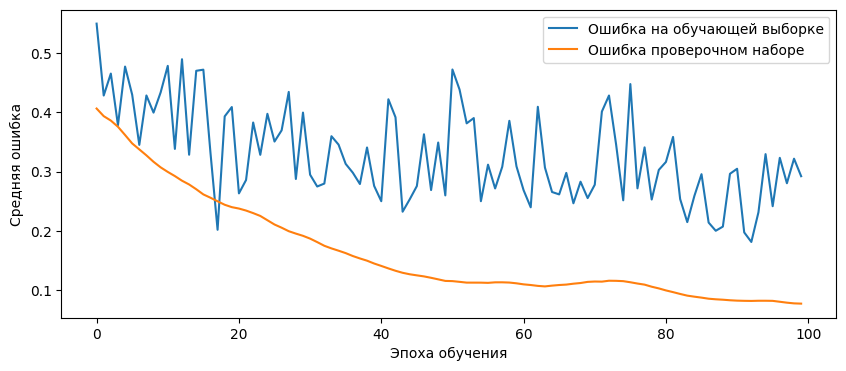

In [99]:
x1 = BatchNormalization()(input1) 
x1 = Dense(1024, activation='relu') (x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(768, activation='sigmoid')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(512, activation='sigmoid')(x1)

x2 = Dense(100, activation='sigmoid') (input2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(100, activation='hard_sigmoid') (x2)


x3 = Dense(100, activation='sigmoid') (input3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.3)(x3)
x3 = Dense(100, activation='hard_sigmoid') (x3)

x = concatenate([x1, x2, x3])

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(50, activation='sigmoid')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2, input3), x) 

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

history = model.fit((x_train, x_train_text1, x_train_text2), 
                    y_train, 
                    epochs= 100, 
                    validation_split = 0.3,
                    verbose=1, shuffle=True)

compare_sharp_loss(history,10,4)                


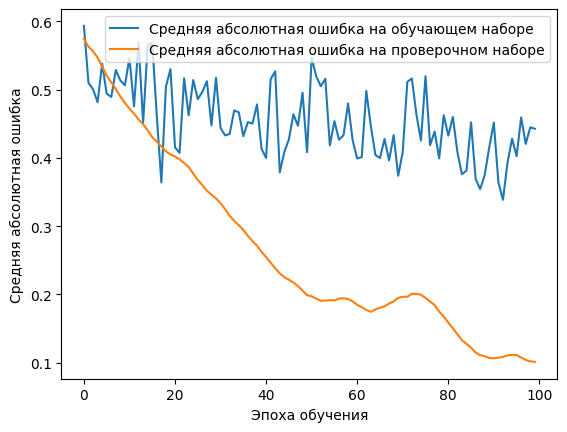

In [100]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

1/1 [==============================] - 0s 238ms/step


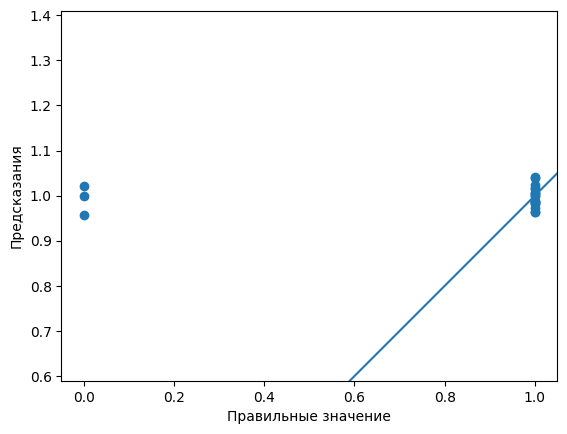

In [101]:
pred = model.predict([x_test, x_test_text1, x_test_text2]) 
plt.scatter(y_test, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 1000], [-1000, 1000])
plt.show()

In [114]:
#Среднеквадратичное отклонение
m_l = []
s = 0
for i in range(0, len(y_test)):
    if np.round(y_test[i]) == np.round(pred[i]):
        s += 1
    dif = (y_test[i] - pred[i])**2
    print(y_test[i], pred[i], dif, np.round(y_test[i]), np.round(pred[i]))
    m_l.append(dif)

print('Среднеквадратичное отклонение', np.sqrt(np.mean(m_l)))
print('Точность модели', s / len(y_test))


1.0 [1.0160362] [0.00025716] 1.0 [1.]
1.0 [1.0246149] [0.00060589] 1.0 [1.]
0.0 [1.020839] [1.0421122] 0.0 [1.]
1.0 [0.9638401] [0.00130754] 1.0 [1.]
1.0 [1.0138928] [0.00019301] 1.0 [1.]
1.0 [1.001463] [2.1405317e-06] 1.0 [1.]
1.0 [1.0050842] [2.5848653e-05] 1.0 [1.]
1.0 [0.98699284] [0.00016919] 1.0 [1.]
1.0 [0.9833507] [0.0002772] 1.0 [1.]
1.0 [0.9880929] [0.00014178] 1.0 [1.]
1.0 [0.96364284] [0.00132184] 1.0 [1.]
1.0 [0.9995608] [1.9292003e-07] 1.0 [1.]
1.0 [1.0420909] [0.00177164] 1.0 [1.]
1.0 [1.0069263] [4.7973605e-05] 1.0 [1.]
0.0 [0.9983471] [0.99669695] 0.0 [1.]
1.0 [0.9729348] [0.00073253] 1.0 [1.]
1.0 [0.9812758] [0.0003506] 1.0 [1.]
1.0 [0.98692924] [0.00017084] 1.0 [1.]
0.0 [0.95675516] [0.9153804] 0.0 [1.]
1.0 [1.038338] [0.0014698] 1.0 [1.]
Среднеквадратичное отклонение 0.38490483
Точность модели 0.85
